## Logistic Regression Experiments

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import random
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import optuna
from optuna.samplers import TPESampler
import joblib

In [2]:
random.seed(42)
np.random.seed(42)

- Load the train and test files 

In [3]:
train_df = pd.read_csv("train_data.csv")
val_df  = pd.read_csv("val_data.csv")
test_df  = pd.read_csv("test_data.csv")

In [4]:
print(f"Train: {len(train_df):>6} rows")
print(f" Val : {len(val_df):>6} rows")
print(f" Test: {len(test_df):>6} rows")

Train:   8000 rows
 Val :   1000 rows
 Test:   1000 rows


## DistilBERT - Experiment 1 (Pretrained Model)

Reference: https://www.byteplus.com/en/topic/496887?title=distilbert-get-embeddings-a-complete-guide

In [5]:
import torch
from transformers import AutoTokenizer, DistilBertModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import joblib

In [6]:
cuda_available = torch.cuda.is_available()
mps_available  = getattr(torch.backends.mps, "is_available", lambda: False)()

if cuda_available:
    device = "cuda"
elif mps_available:
    device = "mps"
else:
    device = "cpu"
print("Using device:", device)

Using device: mps


- Extracting embeddings using pretrained DistilBERT

In [7]:
train_texts = train_df["text"].tolist()
val_texts   = val_df  ["text"].tolist()
y_train     = train_df["sentiment_id"].values
y_val       = val_df  ["sentiment_id"].values

In [8]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased").to(device)
model.eval()

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [9]:
def get_embeddings(texts, batch_size=32):
    all_embeds = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size] #slice text into chunks
        enc = tokenizer(
            batch,
            padding="longest",
            truncation=True,
            return_tensors="pt"
        ).to(device)
        with torch.no_grad():
            last_hidden = model(**enc).last_hidden_state  
        mask   = enc.attention_mask.unsqueeze(-1)      #mask mean pooling step to convert embeddings into single fixed length vector
        summed = (last_hidden * mask).sum(dim=1)      
        counts = mask.sum(dim=1).clamp(min=1e-9)      
        mean_pooled = summed / counts               #mean pooled is the average embedding per review
        all_embeds.append(mean_pooled.cpu().numpy())
    return np.vstack(all_embeds)


In [10]:
# Compute embeddings for train 
X_train_embeds = get_embeddings(train_texts, batch_size=32)
print("Train embeddings shape:", X_train_embeds.shape)
joblib.dump(X_train_embeds, "X_train_embeds_distilbert_experiment1.pkl")

Train embeddings shape: (8000, 768)


['X_train_embeds_distilbert_experiment1.pkl']

In [11]:
# Compute embeddings for  validation
X_val_embeds   = get_embeddings(val_texts,   batch_size=32)
print("Validation embeddings shape:", X_val_embeds.shape)
joblib.dump(X_val_embeds,   "X_val_embeds_distilbert_experiment1.pkl")

Validation embeddings shape: (1000, 768)


['X_val_embeds_distilbert_experiment1.pkl']

- Hyperparameter tuning

In [12]:
def objective(trial):
    C       = trial.suggest_float("C", 1e-5, 1e2, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", "l1", "elasticnet"])
    
    if penalty == "l2":
        solver  = trial.suggest_categorical("solver", ["lbfgs", "sag", "saga"])
        l1_ratio = None
    elif penalty == "l1":
        solver   = "saga"
        l1_ratio  = None
    else:  
        solver   = "saga"
        l1_ratio = trial.suggest_float("l1_ratio", 0.0, 1.0)
    
    params = {
        "C":            C,
        "penalty":      penalty,
        "solver":       solver,
        "class_weight": "balanced",
        "max_iter":     1000,
        "random_state": 42
    }
    if l1_ratio is not None:
        params["l1_ratio"] = l1_ratio

    clf = LogisticRegression(**params)
    clf.fit(X_train_embeds, y_train)
    preds = clf.predict(X_val_embeds)
    return f1_score(y_val, preds, average="macro")

In [13]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

print("Best macro-F1:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-06-22 00:52:27,538] A new study created in memory with name: no-name-2f0e4afb-43fa-4196-b175-e783dd7f27bb
[I 2025-06-22 00:52:28,585] Trial 0 finished with value: 0.648102115308593 and parameters: {'C': 0.0005101782292119372, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 0 with value: 0.648102115308593.
[I 2025-06-22 00:52:28,643] Trial 1 finished with value: 0.061156524371783226 and parameters: {'C': 5.278709087428746e-05, 'penalty': 'l1'}. Best is trial 0 with value: 0.648102115308593.
/opt/miniconda3/envs/text/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[I 2025-06-22 00:53:00,832] Trial 2 finished with value: 0.6679138069144024 and parameters: {'C': 37.37901591712353, 'penalty': 'l2', 'solver': 'sag'}. Best is trial 2 with value: 0.6679138069144024.
[I 2025-06-22 00:53:01,100] Trial 3 finished with value: 0.061156524371783226 and parameters: {'C': 0.000

Best macro-F1: 0.7145571681379222
Best hyperparameters:
  C: 0.855174593958169
  penalty: l2
  solver: lbfgs


- Applying Optimal Parameters for Retraining and Evaluation on the Test Set

In [14]:
test_texts = test_df["text"].tolist()
y_test     = test_df["sentiment_id"].values


X_test_embeds = get_embeddings(test_texts, batch_size=32)
joblib.dump(X_test_embeds,   "X_test_embeds_distilbert_experiment1.pkl")

['X_test_embeds_distilbert_experiment1.pkl']

In [15]:
# retreive train and test set embeddings
X_train_embeds = joblib.load("X_train_embeds_distilbert_experiment1.pkl")
X_test_embeds = joblib.load("X_test_embeds_distilbert_experiment1.pkl")

In [17]:
best = study.best_params
print(best)

{'C': 0.855174593958169, 'penalty': 'l2', 'solver': 'lbfgs'}


In [18]:
# Train Logistic Regression 
LR_distilbert = LogisticRegression(
    C            = best["C"],
    penalty      = best["penalty"],   
    solver       = best["solver"],   
    class_weight = "balanced",
    max_iter     = 1000,
    random_state = 42
)

In [19]:
# Fit on DistilBERT embeddings
LR_distilbert.fit(X_train_embeds, y_train)

LogisticRegression(C=0.855174593958169, class_weight='balanced', max_iter=1000,
                   random_state=42)

In [20]:
test_preds = LR_distilbert.predict(X_test_embeds)

print(classification_report(
    y_test,
    test_preds,
    target_names=["Negative", "Neutral", "Positive"]
))

              precision    recall  f1-score   support

    Negative       0.73      0.81      0.77       160
     Neutral       0.38      0.65      0.48       101
    Positive       0.98      0.86      0.92       739

    accuracy                           0.83      1000
   macro avg       0.70      0.78      0.72      1000
weighted avg       0.88      0.83      0.85      1000



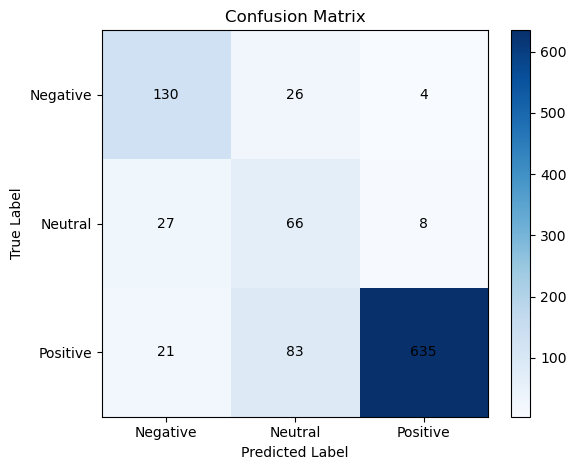

In [21]:
cm = confusion_matrix(test_df["sentiment_id"], test_preds)
labels = ["Negative", "Neutral", "Positive"]

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels)
ax.set_yticks(np.arange(len(labels)))
ax.set_yticklabels(labels)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title("Confusion Matrix")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

In [22]:
joblib.dump(LR_distilbert, "lr_distilbert_experiment1.pkl")
print("Model saved to lr_distilbert_experiment1.pkl")

Model saved to lr_distilbert_experiment1.pkl
